### Instrucciones generales <a class="tocSkip"></a>

1. Forme un grupo de **máximo dos estudiantes**
1. Versione su trabajo usando un **repositorio <font color="red">privado</font> de github**. Agregue a su compañero y a su profesor (usuario github: phuijse) en la pestaña *Settings/Manage access*. No se aceptarán consultas si la tarea no está en github. No se evaluarán tareas que no estén en github.
1. Se evaluará el **resultado, la profundidad de su análisis y la calidad/orden de sus códigos** en base al último commit antes de la fecha y hora de entrega". Se bonificará a quienes muestren un método de trabajo incremental y ordenado según el histórico de *commits*
1. Sean honestos, ríganse por el [código de ética de la ACM](https://www.acm.org/about-acm/code-of-ethics-in-spanish)



# Tarea 2: Filtrado de señales

## Introducción


Un **electrocardiograma (ECG)** es un gráfico de voltaje (amplitud) en función del tiempo correspondiente a la actividad eléctrica del corazón. Cada etapa del ciclo cardíaco es representado por una letra: **P, Q, R, S y T**. La siguiente figura muestra un esquema de un ECG con dos pulsos.

<img src="cardio.png" width="600">


El ECG se usa para hacer diagnósticos y en particular para analizar la existencia de anormalidades en el ciclo cardiaco. La **frecuencia cardiaca**, es decir el inverso del intervalo RR, de un humano normal en reposo está en el rango de **60 y 100 latidos por minuto**



## Enunciado

El hospital base de Valdivia tiene un electrocardiógrafo que mide la ECG en miliVolts [mV] a una frecuencia de muestreo de $360$ [Hz]

Durante el proceso de captura ciertos errores provocaron que la señal se contamine con 

- **(A)** Un ruido asociado al sistema eléctrico
- **(B)** Un ruido de baja frecuencia causado por un desperfecto del sensor
- **(C)** Un ruido blanco de origen térmico 

Esto complica el análisis del médico por lo que el hospital base los contrata a ustedes para **diseñar un filtro que limpie la señal ECG**

Resuelva las actividades que se piden a continuación, respondiendo y analizando donde corresponda

<IPython.core.display.Javascript object>


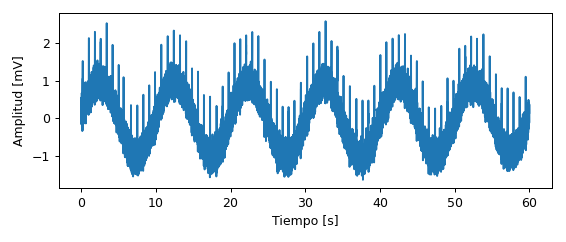

In [3]:
import numpy as np
import pickle
%matplotlib notebook
import matplotlib.pylab as plt

with open("ECG.pkl", "rb") as f:
    data = pickle.load(f)

Fs = 360
time = np.arange(len(data))/Fs
fig, ax = plt.subplots(figsize=(7, 3), tight_layout=True)
ax.plot(time, data)
ax.set_xlabel('Tiempo [s]')
ax.set_ylabel('Amplitud [mV]');

## Análisis (15%)

- Observe los primeros dos segundos de la señal, compare con el esquema mostrado en la introducción y discuta sobre los efectos causados por los ruidos **A**, **B** y **C** mencionados en el enunciado. Además responda  ¿Qué es un ruido blanco y que tipo de efecto introduce en la señal y en su espectro? ¿Qué es una tendencia y que tipo de efecto introduce en la señal y su espectro? 
- Calcule y muestre gráficamente el valor absoluto de la transformada de Fourier de la señal en función de la frecuencia y su espectrograma en función del tiempo y la frecuencia. Para el espectrograma decida el largo de ventana, traslape y tipo de ventana. Justifique su elección tomando en consideración el rango de frecuencias de un paciente normal y los *trade-off* aprendidos en clases
- En base a la señal, su espectro de magnitud y su espectrograma identifique la frecuencia central o el rango de frecuencias asociada a las tres fuentes de ruido. ¿En qué rango de frecuencias (Hz) se espera encontrar la señal de ritmo cardíaco de un humano normal en reposo?


## Filtrado FIR (50%)

Describa lo que es un filtro FIR, explique paso a paso el método de enventanado y describa los argumentos y el valor de retorno de la función `scipy.signal.firwin`. 

Luego use este método para diseñar y aplicar tres filtros sobre la señal de entrada. El primero debe filtrar el ruido **(A)**, el segundo el ruido **(B)** y el tercero el ruido **(C)**. Indique la(s) frecuencia(s) de corte y el tipo de filtro en cada caso. Justifique su elección en base a sus observaciones en el paso anterior.

Considere una ventana de Hamming y $1001$ coeficientes para el filtro

Por cada filtro:
- Muestre la respuesta al impulso y la respuesta en frecuencia resultantes
- Filtre la señal convolucionando con la respuesta al impulso
- Calcule la resta entre la señal original y la señal filtrada. ¿Qué espera observar en este caso? Luego muestre gráficamente el espectro de magnitud y el espectrograma de la señal restada. En base a lo que observa y a los gráficos del punto anterior discuta sobre la efectividad del filtro

Finalmente
- Filtre la señal convolucionando con los tres filtros. Muestre el resultado graficamente. 
- Muestre un acercamiento de los primeros tres segundos de la señal filtrada, reconozca la fase R y márquela con una linea roja punteada.
- Cree una función que mida el tiempo RR en la señal filtrada. Grafique la frecuencia cardiaca en función del tiempo. ¿Se encuentra la persona en el rango sano o no?

## Filtrado IIR (35%)

Describa los filtros IIR y compárelo con los filtros FIR. Describa los argumentos y el valor de retorno de la función `scipy.signal.iirfilter`.

Luego use este método para diseñar tres filtros. Los filtros deben cumplir el mismo propósito que en el caso anterior. Considere filtros IIR de tipo `butterworth` y todos del mismo orden. Aplique los filtros sobre la señal de entrada usando la función `scipy.signal.lfilter`.

El objetivo es encontrar el mínimo orden para los filtros IIR tal que el error medio cuadrático entre la señal filtrada IIR y la señal filtrada FIR sea menor que un 1% de la varianza de la señal filtrada FIR. Es decir que si $x$ es la señal filtrada IIR e $y$ es la señal filtrada FIR donde $N = \min(\text{len}(x), \text{len}(y))$ se cumpla que

$$
\sum_{i=1}^N (x_i - y_i)^2 < 0.01 \sum_{i=1}^N (y_i - \bar y_i)^2
$$

Finalmente, discuta sobre sus hallazgos muestre gráficamente el resultado del mejor filtro IIR


# Solución

## Análisis

### Fragmento de la señal


<IPython.core.display.Javascript object>


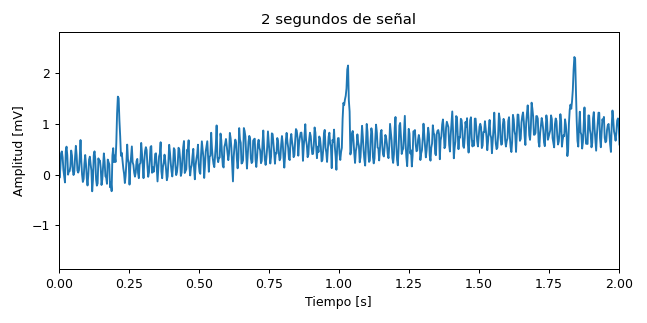

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.fft as sfft
import scipy.signal
from IPython.display import Image, Audio
from ipywidgets import interact, interactive, fixed, interact_manual,widgets
Fs = 360
time = np.arange(len(data))/Fs
fig, ax = plt.subplots(figsize=(8, 4), tight_layout=True)
ax.plot(time, data)
ax.set_xlabel('Tiempo [s]');
ax.set_ylabel('Amplitud [mV]');
ax.set_xlim(0,2);
ax.set_title('2 segundos de señal');


<img src="cardio.png" width="600">

- Al comparar los dos segundos de la señal proporcionada por el hospital con la imagen mostrada en la introducción, podemos diferenciar la etapa Q, R y S del ciclo cardiaco, donde R será la que tenga mas amplitud, Q el inicio de esta y S el final. También se observa que el ciclo RR tiene un período de 0.8 segundos aproximadamente, por lo cual podemos decir que el corazón hace alrededor de 75 latidos por minutos, estando en el rango de un humano normal. Por otro lado, los ruidos **A**, **B** y **C** que se encuentran en este sistema no nos permiten detectar la etapa P y T, ya que los ruidos mencionados anteriormente perturban nuestra señal, por lo que será necesario implementar filtros para disminuir este ruido.  

- El ruido blanco es una señal no correlativa, contiene todas las frecuencias posibles, por lo que su presencia enmascara cualquier otra señal que exista. Podemos apreciar la existencia de este ruido en nuestra señal, ya que nos impide identificar claramente las etapas del ciclo cardiaco en el electrocardiograma.

- Una tendencia tendencia es un patrón de comportamiento de los elementos de un entorno particular durante un período. En una señal estas pueden dificultar el análisis de los datos, ya que la señal puede mostrar patrones generales que no son propios de ellos.

### Transformada de Furier y espectrograma

<IPython.core.display.Javascript object>


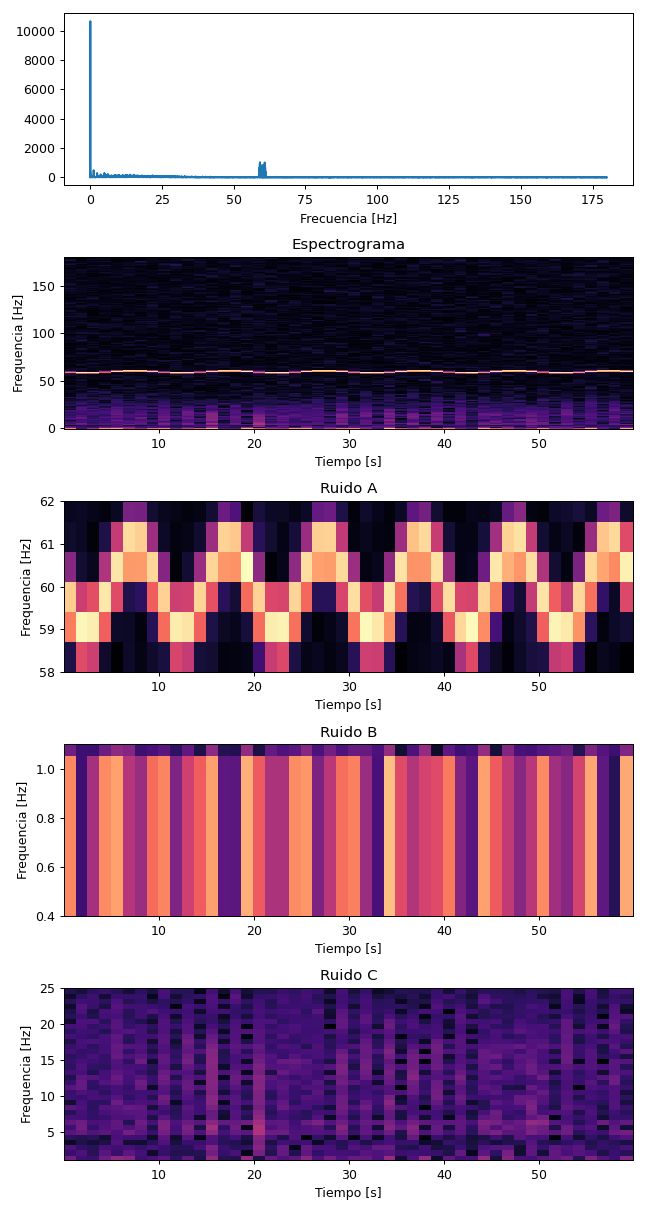

(1.1, 25.0)

In [11]:
fig, ax = plt.subplots(5,figsize=(8, 15), tight_layout=True)
freq = sfft.rfftfreq(n=len(data), d=1./Fs)
S = np.absolute(sfft.rfft(data))
Nw = 512
freqs, times, Sxx = scipy.signal.spectrogram(data,
                                             fs=Fs,
                                             nperseg=Nw,
                                             noverlap=512//8,
                                             mode = 'magnitude',
                                             window=('kaiser',6))
ax[0].plot(freq, S); 
ax[0].set_xlabel('Frecuencia [Hz]');
ax[1].pcolormesh(times, freqs, np.log10(Sxx+1e-1), cmap=plt.cm.magma, shading='auto'); 
ax[1].set_title("Espectrograma")
ax[1].set_ylabel('Frequencia [Hz]');
ax[1].set_xlabel('Tiempo [s]'); 
ax[2].pcolormesh(times, freqs, np.log10(Sxx+1e-1), cmap=plt.cm.magma, shading='auto'); 
ax[2].set_title("Ruido A")
ax[2].set_ylabel('Frequencia [Hz]');
ax[2].set_xlabel('Tiempo [s]'); 
ax[2].set_ylim(58,62)
ax[3].pcolormesh(times, freqs, np.log10(Sxx+1e-1), cmap=plt.cm.magma, shading='auto'); 
ax[3].set_title("Ruido B")
ax[3].set_ylabel('Frequencia [Hz]');
ax[3].set_xlabel('Tiempo [s]'); 
ax[3].set_ylim(0.4,1.1)
ax[4].pcolormesh(times, freqs, np.log10(Sxx+1e-1), cmap=plt.cm.magma, shading='auto'); 
ax[4].set_title("Ruido C")
ax[4].set_ylabel('Frequencia [Hz]');
ax[4].set_xlabel('Tiempo [s]'); 
ax[4].set_ylim(1.1,25)

Para realizar el espectrograma se tomó en cuenta los siguientes parámetros:  
- Largo de ventana: 512
- Traslape: 512/8
- Tipo de ventana: Kaiser

**Falta Justitficacion**

### Frecuencia Central y rango de frecuencias

Podemos observar que la frecuencia central del espectrograma es 60 Hz, tambien podemos decir que el rango del ruido **A** al sistema electrico esta entre 58 y 62 Hz, el ruido **B** esta entre 0.4 y 1.1 Hz aproximadamente y finalmente el ruido **C** esta entre 1.1 y 25 Hz. Dado que la frecuencia cardiaca de una persona normal esta entre 60 y 100 latidos por minutos tenemos lo siguiente.

- Si la frecuenca es de 60 latidos por minuto entonces tenemos una frecuencia de 1 Hz

- Si la frecuencia es de 100 latidos por minutos entonces tenemos una frecuencia de 1.67 Hz

Por lo tanto el rango de la frecuencia cardiaca de una persona normal estara entre 1 y 1.67 Hz

## Filtrado FIR 

##  Filtrado IIR